In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
!pip install gymnasium

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from collections import deque
import pickle

import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
env_id = "CartPole-v1"

# Create the env
env = gym.make(env_id)

# Create the evaluation env
eval_env = gym.make(env_id, render_mode="rgb_array")

# Get the state space and action space
n_actions = env.action_space.n

In [5]:
class Policy(nn.Module):
    def __init__(self, state_size, n_actions, hidden_size, img_size=(64,64), device=torch.device('cpu')):
        super(Policy, self).__init__()
        self.state_size = state_size
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n_actions)
        self.device = device

    def forward(self, x):
        # Layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x

    def act(self, state, exploration=True):

        # Get Action Probabilities
        probs = self.forward(state).cpu()

        # Return Action and LogProb
        action = probs.argmax(dim=-1)
        log_prob = None
        if exploration:
            m = Categorical(probs)
            action = m.sample()
            log_prob = m.log_prob(action)
        return action.item(), log_prob

    def to(self, device):
        ret = super().to(device)
        ret.device = device
        return ret

In [6]:
def evaluate_agent(env, n_eval_episodes, policy):
    episode_rewards = []

    for episode in range(n_eval_episodes):
        state, _ = env.reset() # state reset

        done = trunc = False

        # stats
        total_rewards_ep = 0

        while not done and not trunc:
            # perform action
            action, _ = policy.act(torch.tensor(state).to(device), exploration=False)

            # As in practical 4, we do not consider "truncated" (i.e., reaching the max number of steps)
            # as a termination condition
            state, reward, done, trunc, _ = env.step(action)

            # stats
            total_rewards_ep += reward

        # stats
        episode_rewards.append(total_rewards_ep)

    # stats
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

In [ ]:
def reinforce(policy, optimizer, n_training_episodes=50, gamma=0.99, print_every=10):
    # stats
    scores_deque = deque(maxlen=100)

    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = [] # stores log probs during episode
        rewards = [] # stores rewards during episode

        # init episode
        state, _ = env.reset()
        done = trunc = False

        while not done and not trunc:
            action, log_prob = policy.act(torch.tensor(state).to(device))

            saved_log_probs.append(log_prob)

            state, reward, done, trunc, _ = env.step(action)

            rewards.append(reward)

        scores_deque.append(sum(rewards))


        rewards = np.array(rewards)
        discounts = np.power(gamma, np.arange(len(rewards)))

        policy_loss = 0
        for t in range(len(rewards)):
            # Compute Gt using discounts and rewards
            G = ... # TODO
            # Compute the policy loss term for t using saved_log_probs, G and gamma
            policy_loss += ... # TODO
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if i_episode % print_every == 0:
            print(f'''Episode {i_episode}
                    \tAverage Score: {np.mean(scores_deque)}
                    \tLast Score: {rewards.sum()}
                    \tEval Score: {evaluate_agent(eval_env,5,policy)}''')
            torch.save(policy, 'model.pt')


In [8]:
policy = Policy(env.observation_space.shape[0], n_actions, 32).to(device)
policy = policy.to(device)

In [9]:
optimizer = optim.Adam(policy.parameters(), lr=1e-3)

In [10]:
reinforce(policy, optimizer, n_training_episodes=1000, gamma=0.99, print_every=10)

Episode 10
                    	Average Score: 18.8
                    	Last Score: 45.0
                    	Eval Score: (9.8, 0.9797958971132712)
Episode 20
                    	Average Score: 23.9
                    	Last Score: 26.0
                    	Eval Score: (9.6, 0.7999999999999999)
Episode 30
                    	Average Score: 23.166666666666668
                    	Last Score: 15.0
                    	Eval Score: (9.8, 0.7483314773547882)
Episode 40
                    	Average Score: 21.875
                    	Last Score: 21.0
                    	Eval Score: (11.4, 1.3564659966250536)
Episode 50
                    	Average Score: 21.2
                    	Last Score: 17.0
                    	Eval Score: (12.4, 1.4966629547095764)
Episode 60
                    	Average Score: 22.183333333333334
                    	Last Score: 32.0
                    	Eval Score: (19.6, 2.727636339397171)
Episode 70
                    	Average Score: 24.271428571428572
        

KeyboardInterrupt: 

In [31]:
policy.device


device(type='cpu')

## Test

In [32]:
policy = torch.load('model.pt', map_location=device)
policy = policy.to(device)
policy.eval()

Policy(
  (conv1): Conv2d(4, 32, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=5, bias=True)
  (gs): Grayscale(num_output_channels=1)
  (rs): Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
)

In [33]:
from matplotlib import animation
import matplotlib.pyplot as plt

def save_frames_as_gif(frames, path='./', filename='REINFORCE.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [34]:
def play_agent(env, policy):
    total_reward = 0
    state = env.reset()
    frames_gif=[]
    for i in range(60):
        state,_,_,_,_ = env.step(0)
    step = 0
    done = False
    negative_reward_patience = MAX_PATIENCE
    states = deque(maxlen=4)
    for i in range(policy.n_frames):
        states.append(state)
    while not done:
        
        action, _ = policy.act(states, exploration=False)
        new_state, reward, done, _, _ = env.step(action)
        states.append(new_state)
        if reward >=0:
            negative_reward_patience = MAX_PATIENCE
        else:
            negative_reward_patience -= 1
            if negative_reward_patience == 0:
                done = True
        if done:
            reward = -100
        total_reward += reward
        frames_gif.append(env.render())
        if done:
            break
        state = new_state
    save_frames_as_gif(frames_gif)
    print("Total Reward:", total_reward)

MovieWriter imagemagick unavailable; using Pillow instead.


Total Reward: -109.89999999999998


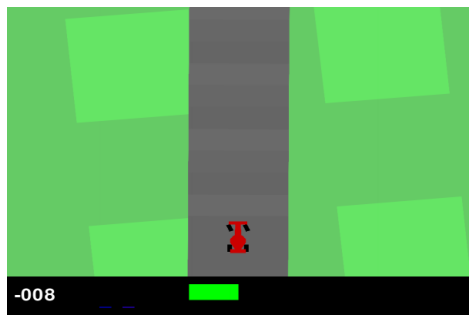

In [35]:
play_agent(eval_env, policy)